In [1]:
# Step 3: Importing Syft
import syft as sy
sy.VERBOSE = False

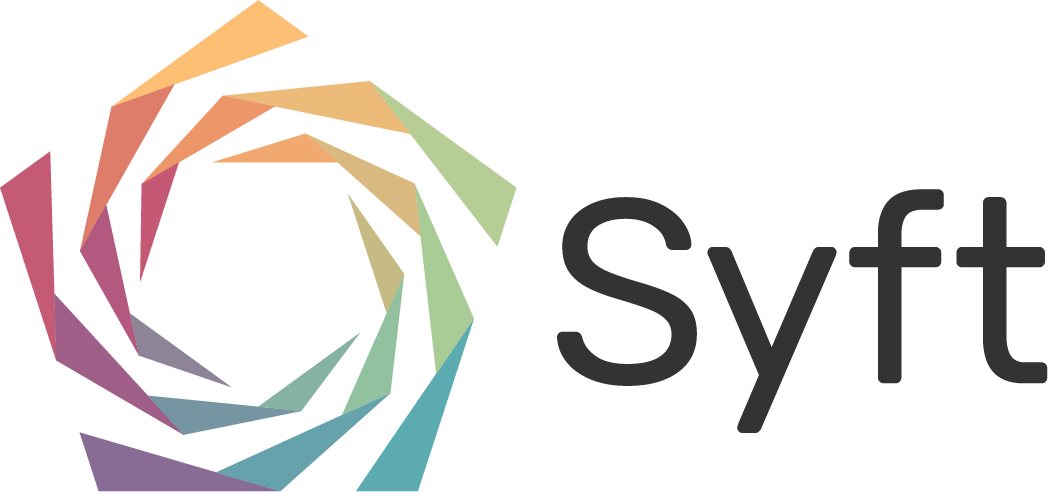

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.

♫♫♫ > 
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!

♫♫♫ > Duet Client ID: a419b3526e7b660cd1b0443c12782103

♫♫♫ > STEP 1: Send the Duet Client ID to your duet partner!

♫♫♫ > ...waiting for partner to connect...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!


In [2]:
duet = sy.join_duet(loopback=True)

In [3]:
duet.store.pandas

,ID,Tags,Description
0,<UID: b842e14907e24e0c8f1e82a1fc0287ca>,[schizophrenia-data],This is a dataset schizophrenia classification...
1,<UID: 7f8b9ee9a1464efe8100b1b987e94373>,[schizophrenia-target],"Class column. 0 = Healthy Control, 1 = Schizop..."


In [4]:
data_ptr = duet.store[0]
target_ptr = duet.store[1]

print(data_ptr)
print(target_ptr)

In [5]:
import torch

In [6]:
in_dim = 50
out_dim = 2
n_samples = 69

In [23]:
class SyNet(sy.Module):
    
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)
        
    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output
        
local_model = SyNet(torch)

> Creating local model


In [24]:
remote_model = local_model.send(duet)

> Sending local model
> Creating remote model
  Sending local layer: layer1
  Sending local layer: layer2
  Sending local layer: out

> Finished sending local model <




In [25]:
remote_torch = duet.torch

In [26]:
params = remote_model.parameters()
optim = remote_torch.optim.Adam(params=params, lr=0.01)

In [27]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):
    
    losses = []
    
    for i in range(iterations):
        
        optim.zero_grad()
        
        output = model(data_ptr)
        
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        loss_item = loss.item()
        
        loss_value = loss_item.get(
                name="loss",
                reason="To evaluate training progress",
                request_block=True,
                timeout_secs=5
            )
        
        if i % 10 == 0:
            print("Epoch", i, "loss", loss_value)
        
        losses.append(loss_value)
        
        loss.backward()
        
        optim.step()
        
    return losses

In [28]:
iteration = 100
losses = train(iteration, remote_model, remote_torch, optim, data_ptr, target_ptr)

Epoch 0 loss 0.6765174865722656
Epoch 10 loss 0.16784191131591797
Epoch 20 loss 0.004556527826935053
Epoch 30 loss 0.00018573463603388518
Epoch 40 loss 3.31718911183998e-05
Epoch 50 loss 1.4234863556339405e-05
Epoch 60 loss 9.629531632526778e-06
Epoch 70 loss 7.857128366595134e-06
Epoch 80 loss 6.946726443857187e-06
Epoch 90 loss 6.369730726873968e-06


In [29]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'iteration')

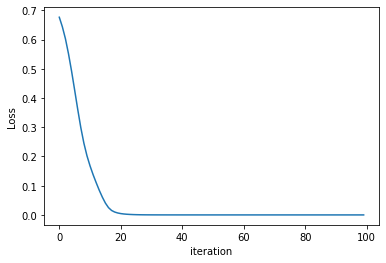

In [30]:
plt.plot(range(iteration), losses)
plt.ylabel('Loss')
plt.xlabel('iteration')

In [31]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            name="model_download",
            reason="To run test and inference locally",
            timeout_secs=5,
        )
    else: 
        local_model = model
        
    return local_model

local_model = get_local_model(remote_model)

> Downloading remote model
> Creating local model

> Finished downloading remote model <




In [32]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [33]:
test_data = pd.read_csv('/Users/zarreennaowalreza/Desktop/openmined/PPMH/schrizofrenia_tab_data/final_test_50.csv')
print(test_data.shape)
test_data.head()

(17, 51)


,FNC40,FNC33,FNC20,SBM_map67,SBM_map61,SBM_map36,SBM_map17,FNC48,FNC37,FNC353,...,FNC289,FNC285,FNC278,FNC275,FNC23,FNC213,FNC211,FNC210,FNC177,Class
0,0.34404,0.64302,0.148900,-0.791032,0.829697,-0.026555,0.187573,0.515280,0.485810,0.273290,...,0.116160,0.11131,-0.14180,0.43596,0.40514,0.49545,0.62594,0.488840,0.15221,0
1,-0.12732,0.25707,0.373060,0.889753,-0.978412,-1.027496,1.961955,0.176950,-0.105510,-0.499290,...,0.110400,0.24471,0.16378,0.14387,-0.34615,0.43485,0.21171,-0.177450,0.19885,1
2,0.34123,0.66877,0.338740,0.785572,-0.896406,-0.213169,0.313224,0.253410,0.098053,-0.316810,...,-0.085182,-0.16643,0.26968,0.57360,-0.25904,0.61563,0.55868,0.447560,-0.36652,1
3,0.24601,0.59077,-0.067104,-1.522856,1.739382,1.574719,-1.308689,-0.033231,-0.304670,0.500520,...,0.078982,-0.51740,-0.57098,0.46945,0.19352,-0.22173,-0.10941,0.336160,-0.13141,0
4,-0.17317,0.51587,0.277670,-0.256770,0.263038,0.833339,-0.051214,0.679640,0.499420,0.083208,...,0.194680,0.21828,0.27271,0.37475,0.69264,0.36131,0.14574,0.027857,-0.11404,0


In [34]:
X_test = test_data.loc[:, test_data.columns != 'Class']
y_test = test_data['Class']

In [35]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

In [36]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 0 Ground Truth: 1
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0


False positive at index 8 and 13

In [37]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc*100)

Overall test accuracy 88.23529411764706
